In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import shutil, os
SRC = "/content/drive/MyDrive/es335-assignment-3"
for fn in [
    "sherlock_tokens.json","sherlock_vocab.json","sherlock_inv_vocab.json","sherlock_X.json","sherlock_y.json",
    "linux_tokens.json","linux_vocab.json","linux_inv_vocab.json","linux_X.json","linux_y.json",
]:
    shutil.copy(os.path.join(SRC, fn), "/content/"+fn)

In [ ]:

import os, json, math, random, time
from pathlib import Path
from typing import List, Tuple
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device & perf knobs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # autotune conv/GEMM
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

print("Device:", DEVICE)

# Load artifacts saved in 1.1
def load_json(p):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

s_tokens = load_json("/content/sherlock_tokens.json")
s_vocab = load_json("/content/sherlock_vocab.json")
s_inv_vocab = load_json("/content/sherlock_inv_vocab.json")
l_tokens = load_json("/content/linux_tokens.json")
l_vocab = load_json("/content/linux_vocab.json")
l_inv_vocab = load_json("/content/linux_inv_vocab.json")

CONTEXT_LEN = 5 
print(f"Sherlock: {len(s_tokens):,} tokens, vocab {len(s_vocab):,}")
print(f"Linux:    {len(l_tokens):,} tokens, vocab {len(l_vocab):,}")


Device: cuda
Sherlock: 115,579 tokens, vocab 8,151
Linux:    1,001,103 tokens, vocab 113,645


In [ ]:
class StreamingNGramDataset(Dataset):
    
    def __init__(self, tokens: List[str], vocab: dict, context_len: int = 5,
                 split: str = "train", val_frac: float = 0.1, seed: int = 1337):
        self.vocab = vocab
        self.context_len = context_len

        ids = np.asarray([vocab[t] for t in tokens], dtype=np.int64)
        max_start = len(ids) - context_len - 1
        idxs = np.arange(max_start + 1, dtype=np.int64)

        # Random split
        rng = np.random.default_rng(seed)
        rng.shuffle(idxs)
        split_at = int((1.0 - val_frac) * len(idxs))
        self.starts = idxs[:split_at] if split == "train" else idxs[split_at:]
        self.ids = ids

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, i):
        s = self.starts[i]
        ctx = self.ids[s : s + self.context_len]
        tgt = self.ids[s + self.context_len]
        return torch.from_numpy(ctx).long(), torch.tensor(tgt).long()

def make_loaders(tokens, vocab, context_len, batch_size=768, val_frac=0.1,
                 num_workers=0, pin=True, prefetch=None, persistent=False):
    train_ds = StreamingNGramDataset(tokens, vocab, context_len, split="train", val_frac=val_frac, seed=SEED)
    val_ds   = StreamingNGramDataset(tokens, vocab, context_len, split="val",   val_frac=val_frac, seed=SEED)

    train_dl = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
        num_workers=num_workers, pin_memory=pin, prefetch_factor=prefetch,
        persistent_workers=persistent
    )
    val_dl = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False,
        num_workers=num_workers, pin_memory=pin, prefetch_factor=prefetch,
        persistent_workers=persistent
    )
    return train_ds, val_ds, train_dl, val_dl


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPTextGen(nn.Module):
    def __init__(self, vocab_size: int, context_len: int,
                 emb_dim: int = 64, hidden_layers: int = 1, hidden_dim: int = 1024,
                 activation: str = "relu", dropout: float = 0.2,
                 use_adaptive_softmax: bool = False, adaptive_cutoffs=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_len = context_len
        self.emb = nn.Embedding(vocab_size, emb_dim)

        act = nn.ReLU if activation.lower() == "relu" else nn.Tanh
        self.act = act()

        in_dim = context_len * emb_dim
        layers = [nn.Linear(in_dim, hidden_dim), self.act, nn.Dropout(dropout)]
        if hidden_layers == 2:
            layers += [nn.Linear(hidden_dim, hidden_dim), self.act, nn.Dropout(dropout)]
        self.mlp = nn.Sequential(*layers)

        self.use_adaptive = use_adaptive_softmax
        if self.use_adaptive:
            # Heuristic cutoffs if not provided
            if adaptive_cutoffs is None:
                cutoff1 = min(20000, vocab_size // 10)
                cutoff2 = min(60000, vocab_size // 2)
                adaptive_cutoffs = [c for c in [cutoff1, cutoff2] if c < vocab_size]
            self.proj = nn.Linear(hidden_dim, emb_dim, bias=False)
            self.adaptive = nn.AdaptiveLogSoftmaxWithLoss(
                in_features=emb_dim, n_classes=vocab_size, cutoffs=adaptive_cutoffs
            )
            self.decoder = None
        else:
            self.proj = nn.Linear(hidden_dim, emb_dim, bias=False)
            self.decoder = nn.Linear(emb_dim, vocab_size, bias=False)
            # weight tying
            self.decoder.weight = self.emb.weight

    def _forward_hidden(self, x):
        # x: (B, context_len)
        emb = self.emb(x)                   # (B, C, E)
        flat = emb.reshape(emb.size(0), -1) # (B, C*E)
        h = self.mlp(flat)                  # (B, H)
        z = self.proj(h)                    # (B, E)
        return z

    def forward(self, x, targets=None, label_smoothing=0.0):
        if self.use_adaptive:
            # Force fp32 for adaptive to avoid dtype mismatch under AMP
            with torch.cuda.amp.autocast(enabled=False):
                z = self._forward_hidden(x).float()
                assert targets is not None, "Targets required with AdaptiveLogSoftmaxWithLoss"
                out = self.adaptive(z, targets)
                loss = out.loss
                # For accuracy:
                pred = self.adaptive.log_prob(z).argmax(dim=-1)
            return loss, pred
        else:
            z = self._forward_hidden(x)     # AMP okay here
            logits = self.decoder(z)
            if targets is None:
                return logits
            loss = F.cross_entropy(logits, targets, label_smoothing=label_smoothing)
            pred = logits.argmax(dim=-1)
            return loss, pred

    @torch.no_grad()
    def log_prob(self, x):
        if self.use_adaptive:
            with torch.cuda.amp.autocast(enabled=False):
                z = self._forward_hidden(x).float()
                return self.adaptive.log_prob(z)
        else:
            z = self._forward_hidden(x)
            return F.log_softmax(self.decoder(z), dim=-1)


In [ ]:
def run_epoch(model, dl, optimizer=None, scaler=None, grad_clip=1.0, accum_steps=1, label_smoothing=0.0):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_correct, total_count = 0.0, 0, 0
    steps = 0

    for i, (ctx, tgt) in enumerate(dl):
        ctx = ctx.to(DEVICE, non_blocking=True)
        tgt = tgt.to(DEVICE, non_blocking=True)

        if is_train:
            with torch.autocast(device_type=DEVICE.type, dtype=torch.float16 if DEVICE.type == "cuda" else torch.bfloat16):
                if model.use_adaptive:
                    loss, pred = model(ctx, targets=tgt, label_smoothing=0.0)  # smoothing not used by adaptive
                else:
                    loss, pred = model(ctx, targets=tgt, label_smoothing=label_smoothing)
                loss = loss / accum_steps

            scaler.scale(loss).backward()
            if ((i + 1) % accum_steps) == 0:
                scaler.unscale_(optimizer)
                if grad_clip is not None:
                    clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        else:
            with torch.no_grad():
                if model.use_adaptive:
                    loss, pred = model(ctx, targets=tgt, label_smoothing=0.0)
                else:
                    loss, pred = model(ctx, targets=tgt, label_smoothing=label_smoothing)

        total_loss += (loss.item() * accum_steps) if is_train else loss.item()
        total_correct += (pred == tgt).sum().item()
        total_count += tgt.numel()
        steps += 1

    avg_loss = total_loss / max(steps, 1)
    acc = total_correct / max(total_count, 1)
    return avg_loss, acc

def plot_curves(history, title):
    plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3380553922.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creatio

[Sherlock][Epoch 01] train_loss=9.2363 val_loss=8.3484 val_acc=0.0902
[Sherlock][Epoch 02] train_loss=8.2928 val_loss=8.0160 val_acc=0.1056
[Sherlock][Epoch 03] train_loss=7.8268 val_loss=7.6958 val_acc=0.1101
[Sherlock][Epoch 04] train_loss=7.4168 val_loss=7.3898 val_acc=0.1133
[Sherlock][Epoch 05] train_loss=7.0693 val_loss=7.1541 val_acc=0.1181
[Sherlock][Epoch 06] train_loss=6.8033 val_loss=6.9771 val_acc=0.1213
[Sherlock][Epoch 07] train_loss=6.5975 val_loss=6.8657 val_acc=0.1205
[Sherlock][Epoch 08] train_loss=6.4363 val_loss=6.7720 val_acc=0.1223
[Sherlock][Epoch 09] train_loss=6.3033 val_loss=6.7066 val_acc=0.1274
[Sherlock][Epoch 10] train_loss=6.1904 val_loss=6.6581 val_acc=0.1273
[Sherlock][Epoch 11] train_loss=6.0929 val_loss=6.6245 val_acc=0.1267
[Sherlock][Epoch 12] train_loss=6.0060 val_loss=6.6056 val_acc=0.1235
[Sherlock][Epoch 13] train_loss=5.9300 val_loss=6.5858 val_acc=0.1274
[Sherlock][Epoch 14] train_loss=5.8619 val_loss=6.5724 val_acc=0.1275
[Sherlock][Epoch 15]

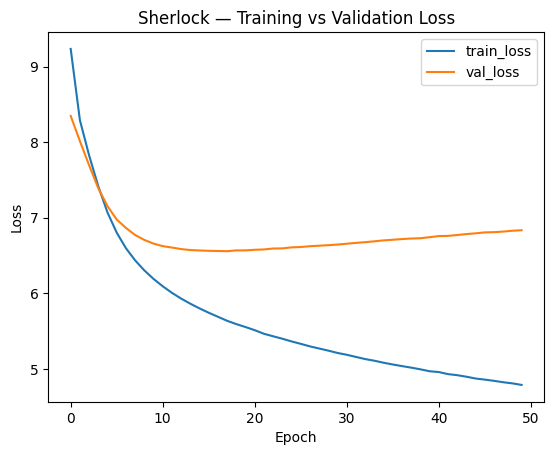

Sherlock Final — val_loss=6.8352, val_acc=0.1203


In [ ]:
# Sherlock: smaller scale, plain softmax is fine & fast
EMB_DIM = 64
HIDDEN_LAYERS = 1      
HIDDEN_DIM = 1024
ACTIVATION = "relu"
DROPOUT = 0.25
USE_ADAPTIVE_SOFTMAX = False  
LABEL_SMOOTH = 0.1            
BATCH_SIZE = 1024
VAL_FRAC = 0.1
EPOCHS = 50                    
LR = 3e-4
WEIGHT_DECAY = 0.01
GRAD_CLIP = 1.0
ACCUM_STEPS = 1               

# Data
s_train_ds, s_val_ds, s_train_dl, s_val_dl = make_loaders(
    s_tokens, s_vocab, CONTEXT_LEN, batch_size=BATCH_SIZE, val_frac=VAL_FRAC,
    num_workers=4, pin=True, prefetch=4, persistent=True
)

# Model
s_model = MLPTextGen(
    vocab_size=len(s_vocab), context_len=CONTEXT_LEN,
    emb_dim=EMB_DIM, hidden_layers=HIDDEN_LAYERS, hidden_dim=HIDDEN_DIM,
    activation=ACTIVATION, dropout=DROPOUT, use_adaptive_softmax=USE_ADAPTIVE_SOFTMAX
).to(DEVICE)

if torch.__version__.startswith("2"):
    try:
        s_model = torch.compile(s_model)
    except Exception as e:
        print("compile skipped:", e)

optimizer = torch.optim.AdamW(s_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

s_hist = {"train_loss": [], "val_loss": [], "val_acc": []}
t0 = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(s_model, s_train_dl, optimizer, scaler,
                                grad_clip=GRAD_CLIP, accum_steps=ACCUM_STEPS, label_smoothing=LABEL_SMOOTH)
    va_loss, va_acc = run_epoch(s_model, s_val_dl, optimizer=None, scaler=None,
                                grad_clip=None, accum_steps=1, label_smoothing=LABEL_SMOOTH)
    s_hist["train_loss"].append(tr_loss)
    s_hist["val_loss"].append(va_loss)
    s_hist["val_acc"].append(va_acc)
    print(f"[Sherlock][Epoch {epoch:02d}] train_loss={tr_loss:.4f} val_loss={va_loss:.4f} val_acc={va_acc:.4f}")
print(f"Sherlock training time: {time.time()-t0:.1f}s")

plot_curves(s_hist, "Sherlock — Training vs Validation Loss")
print(f"Sherlock Final — val_loss={s_hist['val_loss'][-1]:.4f}, val_acc={s_hist['val_acc'][-1]:.4f}")


/tmp/ipython-input-3511846890.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_l = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))


[Linux][Epoch 01] train_loss=7.6518 val_loss=6.3320 val_acc=0.3053
[Linux][Epoch 02] train_loss=5.9791 val_loss=6.0442 val_acc=0.3171
[Linux][Epoch 03] train_loss=5.7119 val_loss=5.8959 val_acc=0.3265
[Linux][Epoch 04] train_loss=5.5366 val_loss=5.7916 val_acc=0.3341
[Linux][Epoch 05] train_loss=5.3874 val_loss=5.6758 val_acc=0.3420
[Linux][Epoch 06] train_loss=5.2586 val_loss=5.5842 val_acc=0.3476
[Linux][Epoch 07] train_loss=5.1413 val_loss=5.5035 val_acc=0.3545
[Linux][Epoch 08] train_loss=5.0395 val_loss=5.4397 val_acc=0.3581
[Linux][Epoch 09] train_loss=4.9509 val_loss=5.3938 val_acc=0.3608
[Linux][Epoch 10] train_loss=4.8696 val_loss=5.3442 val_acc=0.3649
[Linux][Epoch 11] train_loss=4.7975 val_loss=5.3092 val_acc=0.3680
[Linux][Epoch 12] train_loss=4.7289 val_loss=5.2713 val_acc=0.3692
[Linux][Epoch 13] train_loss=4.6640 val_loss=5.2444 val_acc=0.3718
[Linux][Epoch 14] train_loss=4.6043 val_loss=5.2121 val_acc=0.3732
[Linux][Epoch 15] train_loss=4.5469 val_loss=5.2020 val_acc=0.

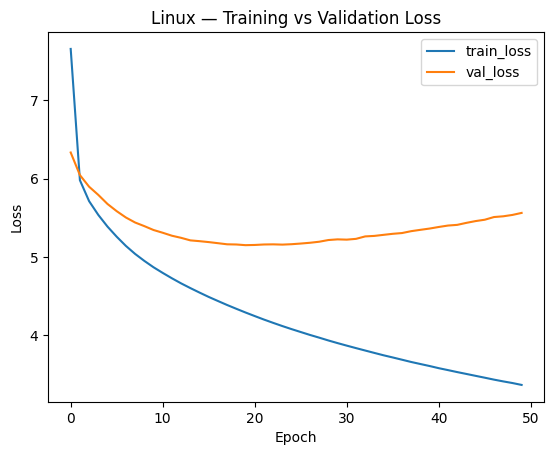

Linux Final — val_loss=5.5621, val_acc=0.4003


In [ ]:

EMB_DIM_L = 64
HIDDEN_LAYERS_L = 1         
HIDDEN_DIM_L = 1024
ACTIVATION_L = "relu"
DROPOUT_L = 0.3
USE_ADAPTIVE_SOFTMAX_L = True   
LABEL_SMOOTH_L = 0.1            
BATCH_SIZE_L = 1024             
VAL_FRAC_L = 0.1
EPOCHS_L = 50                    
LR_L = 3e-4
WEIGHT_DECAY_L = 0.01
GRAD_CLIP_L = 1.0
ACCUM_STEPS_L = 1

l_train_ds, l_val_ds, l_train_dl, l_val_dl = make_loaders(
    l_tokens, l_vocab, CONTEXT_LEN, batch_size=BATCH_SIZE_L, val_frac=VAL_FRAC_L,
    num_workers=0, pin=False, persistent=False
)

# Rebuild Linux model after patch
l_model = MLPTextGen(
    vocab_size=len(l_vocab), context_len=CONTEXT_LEN,
    emb_dim=EMB_DIM_L, hidden_layers=HIDDEN_LAYERS_L, hidden_dim=HIDDEN_DIM_L,
    activation=ACTIVATION_L, dropout=DROPOUT_L,
    use_adaptive_softmax=USE_ADAPTIVE_SOFTMAX_L
).to(DEVICE)

if torch.__version__.startswith("2"):
    try:
        l_model = torch.compile(l_model)
    except Exception as e:
        print("compile skipped:", e)

optimizer_l = torch.optim.AdamW(l_model.parameters(), lr=LR_L, weight_decay=WEIGHT_DECAY_L)
scaler_l = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

# Train loop (same as before)
l_hist = {"train_loss": [], "val_loss": [], "val_acc": []}
for epoch in range(1, EPOCHS_L+1):
    tr_loss, tr_acc = run_epoch(l_model, l_train_dl, optimizer_l, scaler_l,
                                grad_clip=GRAD_CLIP_L, accum_steps=ACCUM_STEPS_L, label_smoothing=LABEL_SMOOTH_L)
    va_loss, va_acc = run_epoch(l_model, l_val_dl, optimizer=None, scaler=None,
                                grad_clip=None, accum_steps=1, label_smoothing=LABEL_SMOOTH_L)
    l_hist["train_loss"].append(tr_loss)
    l_hist["val_loss"].append(va_loss)
    l_hist["val_acc"].append(va_acc)
    print(f"[Linux][Epoch {epoch:02d}] train_loss={tr_loss:.4f} val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

plot_curves(l_hist, "Linux — Training vs Validation Loss")
print(f"Linux Final — val_loss={l_hist['val_loss'][-1]:.4f}, val_acc={l_hist['val_acc'][-1]:.4f}")


In [ ]:
#save
import os
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/Model_Checkpoints/weights")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Sherlock model checkpoint
s_checkpoint = {
    "model_state": s_model.state_dict(),
    "config": {
        "vocab_size": len(s_vocab),
        "context_len": CONTEXT_LEN,
        "emb_dim": EMB_DIM,
        "hidden_layers": HIDDEN_LAYERS,
        "hidden_dim": HIDDEN_DIM,
        "activation": ACTIVATION,
        "dropout": DROPOUT,
        "use_adaptive_softmax": USE_ADAPTIVE_SOFTMAX,
        "label_smoothing": LABEL_SMOOTH,
    },
    "vocab": s_vocab,
    "inv_vocab": s_inv_vocab,
}
torch.save(s_checkpoint, SAVE_DIR / "sherlock_mlp.pt")

# Linux model checkpoint
l_checkpoint = {
    "model_state": l_model.state_dict(),
    "config": {
        "vocab_size": len(l_vocab),
        "context_len": CONTEXT_LEN,
        "emb_dim": EMB_DIM_L,
        "hidden_layers": HIDDEN_LAYERS_L,
        "hidden_dim": HIDDEN_DIM_L,
        "activation": ACTIVATION_L,
        "dropout": DROPOUT_L,
        "use_adaptive_softmax": USE_ADAPTIVE_SOFTMAX_L,
        "label_smoothing": LABEL_SMOOTH_L,
    },
    "vocab": l_vocab,
    "inv_vocab": l_inv_vocab,
}
torch.save(l_checkpoint, SAVE_DIR / "linux_mlp.pt")

print("Models saved:")
print(f"- Sherlock: {SAVE_DIR / 'sherlock_mlp.pt'}")
print(f"- Linux:    {SAVE_DIR / 'linux_mlp.pt'}")


Models saved:
- Sherlock: /content/drive/MyDrive/Model_Checkpoints/weights/sherlock_mlp.pt
- Linux:    /content/drive/MyDrive/Model_Checkpoints/weights/linux_mlp.pt
